In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "emopain_svm"

data_types = ["emg", "energy", "angle"]
encoders = ["rate"] # ["STL-V", "STL-S", "rate", "latency"]

data = []
filenames = []
for data_type in data_types:
    for encoder in encoders:
        results = pd.read_csv(f'../results/{file}/results_{data_type}_{encoder}.csv', index_col=0)
        filenames.append(f"{file} {data_type} {encoder}")
        results.set_index('fold', inplace=True)
        results.index = results.index.astype(int)
        # deduplicate the fold index
        results = results[~results.index.duplicated(keep='first')]
        results['test_preds'] = results['test_preds'].apply(lambda x: int(x.strip('[]')))
        results['test_labels'] = results['test_labels'].apply(lambda x: int(x.strip('[]')))
        print(f'{data_type}_{encoder}: {results.shape}')
        results.sort_index()
        
        data.append(results)

data[0].head()

emg_rate: (46, 6)
energy_rate: (46, 6)
angle_rate: (46, 6)


,train_acc,val_acc,test_acc,test_preds,test_labels,sparsity
fold,,,,,,
0,-1,-1,100.0,0,0,0.038345
1,-1,-1,100.0,0,0,0.058687
2,-1,-1,100.0,0,0,0.045463
3,-1,-1,100.0,0,0,0.056270
4,-1,-1,100.0,0,0,0.035030


In [61]:

results_dict = {}
for i, d in enumerate(data):
    file, data_type, encoder = filenames[i].split(" ")
    filename = f"{file}_{data_type}_{encoder}"
    print(file, data_type, encoder)
    
    accuracies = d["test_acc"]
    sparsities = d["sparsity"]
    preds = d["test_preds"].to_numpy().flatten()
    labels = d["test_labels"].to_numpy().flatten()
    print(np.mean(accuracies))
    print(np.mean(sparsities))
    
    try:
        results_dict[filename]["accuracies"].append(np.mean(accuracies))
        results_dict[filename]["sparsities"].append(np.mean(sparsities))
        results_dict[filename]["labels"].append(labels)
        results_dict[filename]["preds"].append(preds)
    except:
        results_dict[filename] = {"accuracies": [np.mean(accuracies)],
                                  "sparsities": [np.mean(sparsities)],
                                  "preds": [preds],
                                  "labels": [labels]}
results_dict

emopain_svm emg rate
65.21739130434783
0.06816956521739127
emopain_svm energy rate
63.04347826086956
0.5835318719806764
emopain_svm angle rate
54.34782608695652
0.7028106642512076


{'emopain_svm_emg_rate': {'accuracies': [65.21739130434783],
  'sparsities': [0.06816956521739127],
  'preds': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
          0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
          0, 1])],
  'labels': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
          0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
          0, 1])]},
 'emopain_svm_energy_rate': {'accuracies': [63.04347826086956],
  'sparsities': [0.5835318719806764],
  'preds': [array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
          0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
          0, 0])],
  'labels': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
          0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
          0, 1])]},
 'emopain_svm_angle_rate': {'accuracies': [54.34782608695652],
  'sparsiti

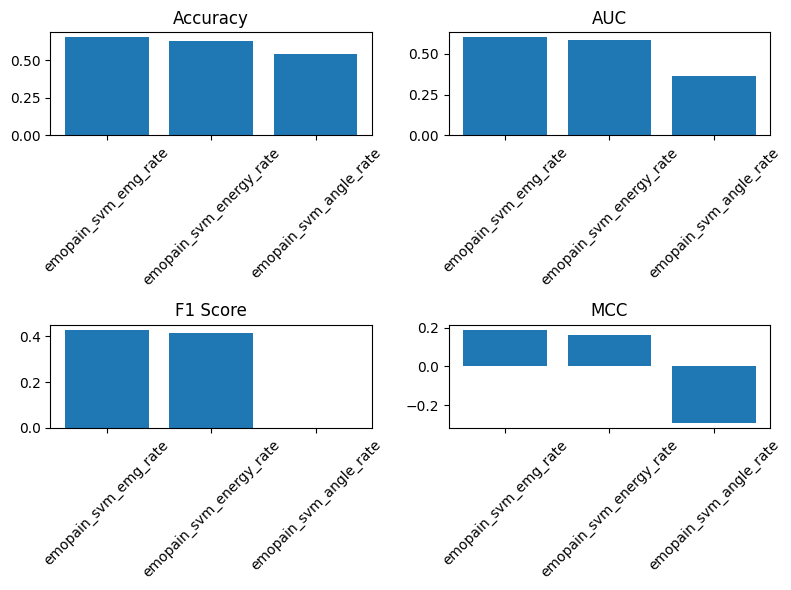

Harmonic mean sparsity: 0.1684838240522863


In [69]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, matthews_corrcoef
from scipy.stats import hmean

metrics = {
    'data_type': [],
    'accuracy': [],
    'auc': [],
    'f1': [],
    'mcc': []
}

for data_type, data in results_dict.items():
    preds = data['preds'][0]
    labels = data['labels'][0]
    
    accuracy = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    
    metrics['data_type'].append(data_type)
    metrics['accuracy'].append(accuracy)
    metrics['auc'].append(auc)
    metrics['f1'].append(f1)
    metrics['mcc'].append(mcc)

metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.bar(metrics_df['data_type'], metrics_df['accuracy'])
plt.title('Accuracy')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.bar(metrics_df['data_type'], metrics_df['auc'])
plt.title('AUC')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.bar(metrics_df['data_type'], metrics_df['f1'])
plt.title('F1 Score')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.bar(metrics_df['data_type'], metrics_df['mcc'])
plt.title('MCC')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate the harmonic mean sparsity
sparsities = [
    results_dict['emopain_svm_emg_rate']['sparsities'][0],
    results_dict['emopain_svm_energy_rate']['sparsities'][0],
    results_dict['emopain_svm_angle_rate']['sparsities'][0]
]

harmonic_mean_sparsity = hmean(sparsities)
print(f'Harmonic mean sparsity: {harmonic_mean_sparsity}')

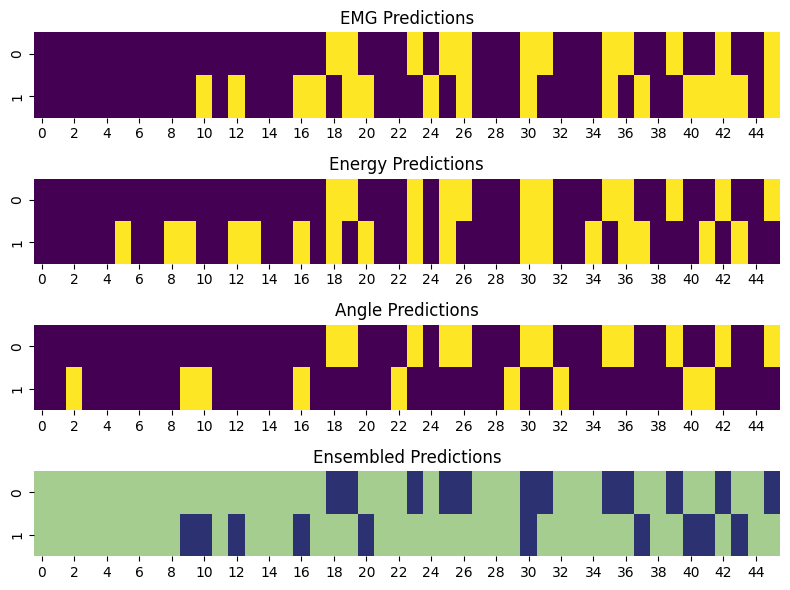

Ensemble Accuracy: 0.5652173913043478
Ensemble AUC: 0.4093137254901961
Ensemble F1 Score: 0.0909090909090909
Ensemble MCC: -0.19308582308458774


In [68]:
import seaborn as sns

# Extract predictions and labels
emg_preds = results_dict['emopain_svm_emg_rate']['preds'][0]
energy_preds = results_dict['emopain_svm_energy_rate']['preds'][0]
angle_preds = results_dict['emopain_svm_angle_rate']['preds'][0]
labels = results_dict['emopain_svm_emg_rate']['labels'][0]  # Assuming labels are the same for all data types

# Calculate accuracy weights
emg_acc = results_dict['emopain_svm_emg_rate']['accuracies'][0]
energy_acc = results_dict['emopain_svm_energy_rate']['accuracies'][0]
angle_acc = results_dict['emopain_svm_angle_rate']['accuracies'][0]

weights = [emg_acc, energy_acc, angle_acc]

# Perform accuracy-weighted majority voting
ensemble_preds = np.round(
    (emg_preds * weights[0] + energy_preds * weights[1] + angle_preds * weights[2]) / sum(weights)
).astype(int)

# Plot individual and ensemble predictions
fig, axs = plt.subplots(4, 1, figsize=(8,6))

sns.heatmap(np.vstack([labels, emg_preds]), ax=axs[0], cbar=False, cmap='viridis')
axs[0].set_title('EMG Predictions')

sns.heatmap(np.vstack([labels, energy_preds]), ax=axs[1], cbar=False, cmap='viridis')
axs[1].set_title('Energy Predictions')

sns.heatmap(np.vstack([labels, angle_preds]), ax=axs[2], cbar=False, cmap='viridis')
axs[2].set_title('Angle Predictions')

sns.heatmap(np.vstack([labels, ensemble_preds]), cbar=False, cmap='crest')
plt.title('Ensembled Predictions')

plt.tight_layout()
plt.show()

# Calculate and print ensemble performance metrics
ensemble_accuracy = accuracy_score(labels, ensemble_preds)
ensemble_auc = roc_auc_score(labels, ensemble_preds)
ensemble_f1 = f1_score(labels, ensemble_preds)
ensemble_mcc = matthews_corrcoef(labels, ensemble_preds)

print(f'Ensemble Accuracy: {ensemble_accuracy}')
print(f'Ensemble AUC: {ensemble_auc}')
print(f'Ensemble F1 Score: {ensemble_f1}')
print(f'Ensemble MCC: {ensemble_mcc}')
